In [3]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']

input_names = ['HIST']
climatology_files = ['air.2m.timemean.nc']
title='Near surface (2m) air tempereature vs. NCEP2'
climatology_path = '/p/project/chhb19/streffing1/obs/NCEP2/'
exps = range(0, 1)
figsize=(6, 4.5)
dpi = 300
ofile = None
res = [192, 94]
variable = ['T2M']
variable_clim = 'air'
levels = np.linspace(-8, 8, 17)
contour_outline_thickness = 0

In [5]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [6]:
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [7]:
# Mean Deviation
def md(predictions, targets):
    return (predictions - targets).mean()


In [8]:
# Load NCEP2 reanalysis data

ERA5_path = climatology_path+climatology_files[0]
ERA5_CRF = cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(ERA5_path),returnArray="air")


In [9]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        paths = []
        data[exp_name][v] = []
        path = exp_path+'T2M_for_plot_timmean.nc'
        data[exp_name][v].append(cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=v))

(94, 192)
(94, 192)
(94, 193)
(94, 193)


convert: unable to open image 'T2M_vs_NCEP2': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `T2M_vs_NCEP2_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'T2M_vs_NCEP2_trimmed.png': No such file or directory


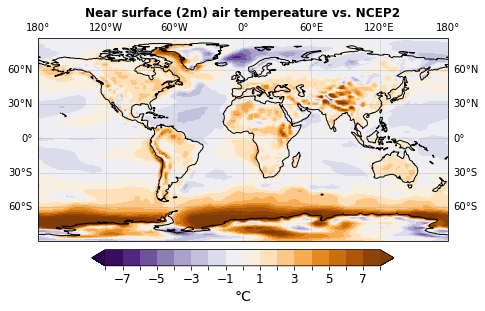

In [12]:
data_model = OrderedDict()
data_model_mean = OrderedDict()


for exp_name in input_names:
    data_model[exp_name] = np.squeeze(data[exp_name]['T2M']) 
    data_model_mean[exp_name] = data_model[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.mean(data_model_mean[exp_name],axis=0)
data_reanalysis_mean = np.mean(np.mean(ERA5_CRF,axis=0),axis=0)

print(np.shape(data_model_mean[exp_name]))
print(np.shape(data_reanalysis_mean))

lon = np.arange(0, 360, 1.875)
lat = np.arange(-90, 90, 1.875)
data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)


lon = np.arange(0, 360, 1.875)
lat = np.arange(-90, 90, 180/94)
data_reanalysis_mean, lon = add_cyclic_point(data_reanalysis_mean, coord=lon)

print(np.shape(data_model_mean[exp_name]))
print(np.shape(data_reanalysis_mean))


rmsdval = rmsd(data_model_mean[exp_name],data_reanalysis_mean)
mdval = md(data_model_mean[exp_name],data_reanalysis_mean)


nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, data_model_mean[exp_name]-
                    data_reanalysis_mean, cmap=plt.cm.PuOr_r, 
                     levels=levels, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, data_model_mean[exp_name]-
                    data_reanalysis_mean, colors=line_colors, 
                    levels=levels, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('K')
    axes[i].set_xlabel('Simulation Year')
    
    axes[i].set_title(title,fontweight="bold")
    plt.tight_layout() 
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False
    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label="°C", size='14')
    cb.ax.tick_params(labelsize='12')
    #plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
    #plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))
    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

    
ofile=variable[0]+'_vs_NCEP2'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')